In [1]:
import pandas as pd
import os
import sys
import re
import statsmodels.api as sm
import seaborn as sns

from pathlib import Path
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from src.import_downcasting import import_downcasting
from src.utils import gen_weekday_num, ts_sales_plot, adf_test_autolag
from src.unitrootTest import searchStationarySeriesADF

ModuleNotFoundError: No module named 'src'

In [ ]:
root = os.path.join(Path(Path(os.getcwd()).parent.absolute()), 'assets/data')


calendar = import_downcasting(os.path.join(root, "raw/calendar.csv"))
# sales = import_downcasting(os.path.join(root, "sales_train_evaluation.csv"))
sell_price = import_downcasting(os.path.join(root, "raw/sell_prices.csv"))

# sales_ca1 = sales[sales.store_id == "CA_1"]
# sales_ca1.to_csv(os.path.join(root, "sales_ca1.csv"), index=False)
# del sales

In [ ]:
sales_ca1 = import_downcasting(os.path.join(root, "sales_ca1.csv"))
sales_ca1 = pd.melt(sales_ca1, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name="date_code", value_name ="sales")
sales_ca1 = pd.merge(left=sales_ca1, right=calendar, left_on='date_code', right_on='d', how='left')
sales_ca1 = pd.merge(left=sales_ca1, right=sell_price, left_on=['store_id', 'item_id', 'wm_yr_wk'], right_on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
sales_ca1['weekday_num'] = sales_ca1['weekday'].apply(gen_weekday_num)

In [ ]:
ranked_item_unit = sales_ca1.groupby(['item_id'])['sales'].sum().sort_values(ascending=False).reset_index()
sales_ca1_rank1 = sales_ca1[sales_ca1.item_id == 'FOODS_3_090'].reset_index(drop=True)
sales_ca1_rank1 = sales_ca1_rank1.set_index('date')

<AxesSubplot:xlabel='weekday_num', ylabel='sales'>

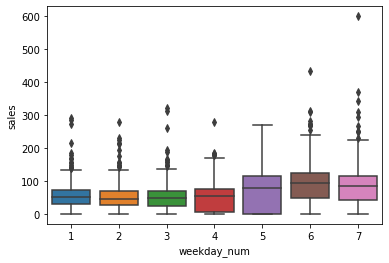

In [ ]:
sns.boxplot(x="weekday_num", y='sales', data=sales_ca1_rank1, order=[1,2,3,4,5,6,7])

<Figure size 432x288 with 0 Axes>

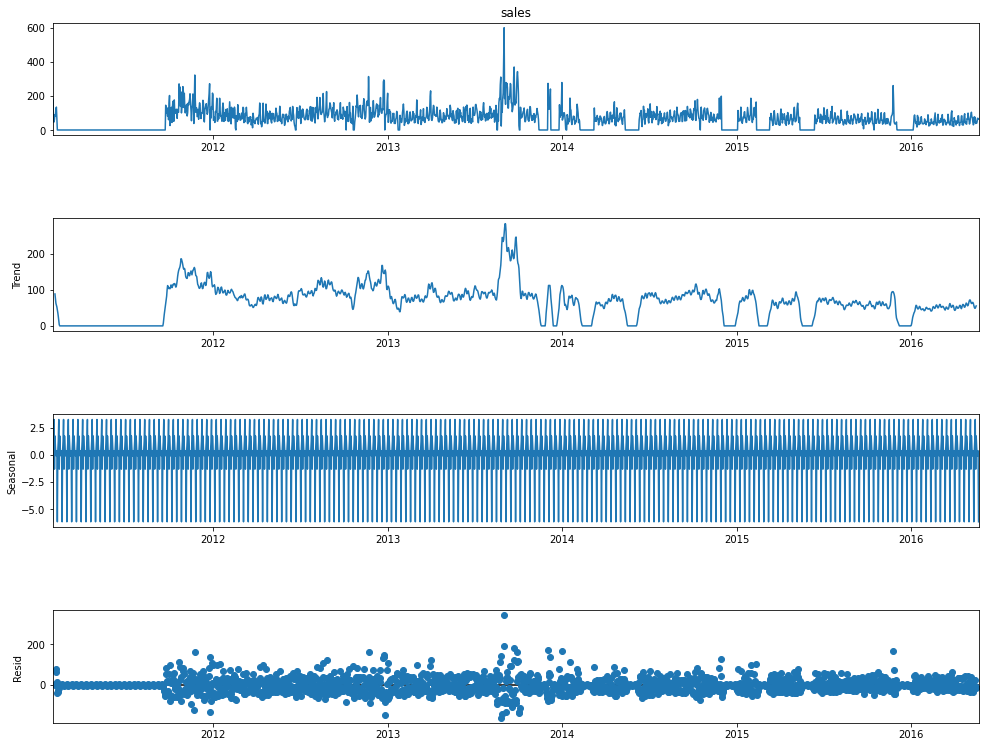

In [ ]:
result = seasonal_decompose(sales_ca1_rank1['sales'], model='additive', period=10)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)


# month_year = sales_ca1_rank1.groupby(['year', 'month']).sales.sum().reset_index()
# month_year = month_year[month_year.year > 2013].reset_index()
# sns.barplot(data=month_year, x=month_year.index, y='sales')

In [ ]:
sales_ca1_rank1['sales_first_diff'] = sales_ca1_rank1['sales'] - sales_ca1_rank1['sales'].shift(1)
sales_ca1_rank1 = sales_ca1_rank1.loc[sales_ca1_rank1['sales_first_diff'].notnull()]

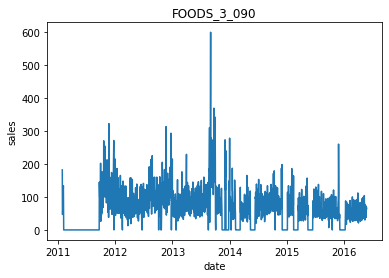

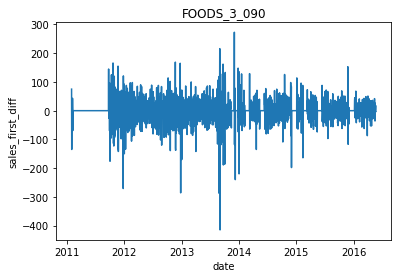

In [ ]:
ts_sales_plot(sales_ca1_rank1, 'sales')
ts_sales_plot(sales_ca1_rank1, 'sales_first_diff')


In [ ]:
rest = adfuller(sales_ca1_rank1['sales'])
print(rest)
print(type(rest))

(-4.081872242123399, 0.001037548189897328, 23, 1916, {'1%': -3.433767579644038, '5%': -2.8630496663460607, '10%': -2.567573687930666}, 19066.746947900694)
<class 'tuple'>


In [ ]:
searchStationarySeriesADF(sales_ca1_rank1['sales'])

Results of Dickey-Fuller Test:
Test Statistic                -14.731143
p-value                              0.0
#Lags Used                           1.0
Number of Observations Used       1938.0
Critical Value (1%)            -3.433729
Critical Value (5%)            -2.863033
Critical Value (10%)           -2.567565
dtype: object


/home/npanj/.local/share/virtualenvs/m5-forecasting-accuracy-_ysVpyC2/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


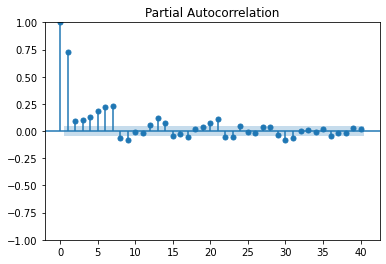

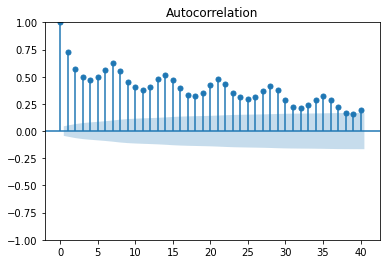

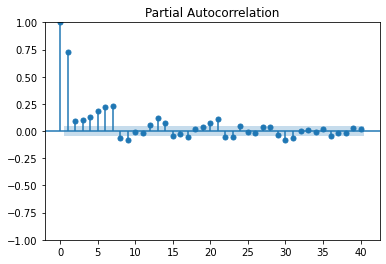

In [ ]:
sm.graphics.tsa.plot_acf(sales_ca1_rank1.sales, lags=40) 
sm.graphics.tsa.plot_pacf(sales_ca1_rank1.sales, lags=40) 

/home/npanj/.local/share/virtualenvs/m5-forecasting-accuracy-_ysVpyC2/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


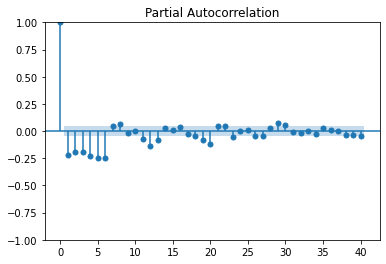

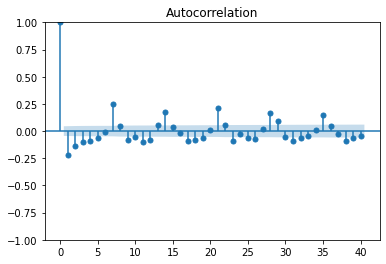

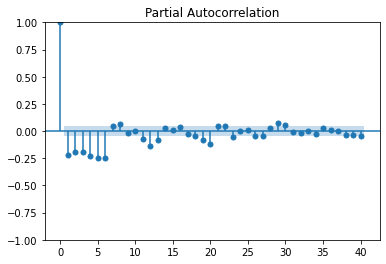

In [ ]:
sm.graphics.tsa.plot_acf(sales_ca1_rank1.sales_first_diff, lags=40) 
sm.graphics.tsa.plot_pacf(sales_ca1_rank1.sales_first_diff, lags=40) 

In [ ]:
def test(num):
    for i in range(num):
        if i == 2:
            return i
        elif i > 4:
            return i

test(10)

2